# Example predictions of the Elephant CNN

To use this notebook, open it as a Jupyter Notebook in the browser. Use Python 3 with standard packages as described below ('import dependencies'), plus the deep learning framework of [Keras](https://keras.io/) with a Tensorflow backend. (Python 2 should work as well.) Since no GPU support is needed here, installation of the required packages should not take more than 5 minutes.

The purpose of this Notebook is to show typical predictions of the team 5 algorithm for example data of the test dataset. All code to load the raw data, to define the CNN model, to perform predictions and to plot example data is included in the Notebook.

### How do typical predictions of the CNN look like?

And how do they compare to the electrophysiological ground truth? - Scroll down to the very end of this Notebook, there are plenty of examples.

### Which CNN model is used by this notebook?

This notebook uses the architecture described in the paper. As described in the paper in more detail, the basis model was re-trained based on statistical properties of the test dataset upon which it is applied. This re-training was performed with a normalized weight assigned to each of the 10 training datasets (0.91, 0.45, 0.05, 0.29, 0.01, 0.11, 0.17, 0.15, 1.00, 0.18 for the datasets 1-10). That is, the model was primarily retrained using training data from the datasets 9, 1, 2 and 4. Therefore, this model is optimized for the test dataset no. 1.

### How will this model perform on other datasets?

This model will perform better if the dataset is similar to the training dataset 1 in terms of statistical properties. For optimal performance, re-training of the network based on the statistical properties of the dataset of interest is a good idea. This can be easily done using the [demo Notebook](https://github.com/PTRRupprecht/Spikefinder-Elephant/blob/master/Demo.ipynb) provided in the main repository.

### I want to retrain/modify the model!

Then this is not the right Notebook to start with. Please check out the readme provided in the [main repository](https://github.com/PTRRupprecht/Spikefinder-Elephant) of the Elephant algorithm for spikefinding.

### Further information

This code was written by [@PTRRupprecht](https://github.com/PTRRupprecht). The Elephant CNN network for spikefinding was developed by P. Rupprecht, [@PTRRupprecht](https://github.com/PTRRupprecht) and S. Gerhard, [@unidesigner](https://github.com/unidesigner) in the lab of [R. Friedrich](http://www.fmi.ch/research/groupleader/?group=119) at the Friedrich Miescher Institute in Basel/Switzerland, as part of the Spikefinder coding challenge 2017 (http://spikefinder.codeneuro.org/).

For more detailed documentation and instructions on how to apply the code to your own calcium imaging data, please have a look at the [Github repository](https://github.com/PTRRupprecht/Spikefinder-Elephant).

# Import dependencies
Import packages (pandas, numpy for data handling; matplotlib, seaborn for plotting; keras for deep learning; print_function for back-compatibility with Python2 )

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import Sequential, Model
from keras.layers import  Dense, Dropout, Flatten, MaxPooling1D, Conv1D, Input
from keras.utils import np_utils
from keras import metrics

from __future__ import print_function

Using TensorFlow backend.


# Set parameters
Set parameters for preprocessing of the data (e.g., smoothing kernel).

In [2]:
# Define some parameters (fixed parameters)

# determines how the time window used as input is positioned around the actual time point
before_frac, after_frac = 0.25, 0.75

# width of gaussian kernel used for convolution of spike train
spike_SD_kernel = 2.0 # half-size of kernel
spike_size_kernel = 15

# key: dataset number, value: list of neuron ids (zero-indexed)
datasets_to_train = {1: [0,1,2,3,4,5,6,7,8,9,10]}
datasets_to_test = {1: [0,1,2,3,4]}

# Load data
Load calcium imaging data and ground truth from training dataset 1 and test dataset 1.

In [3]:
# Loading training and test data for dataset 1
print('Loading dataset ...', end='')

# Define helper function for normalization
def norm(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-7)

n_dataset = 1 # dataset number 1

# kernel for smoothing the ground truth (spikes) to facilitate gradient descent
kernelX = np.exp(-(np.array(range(-spike_size_kernel,spike_size_kernel+1),'float32'))**2/spike_SD_kernel**2)
kernelX = kernelX/np.sum(kernelX)

# load training data using pandas
x_train = pd.read_csv("../%d.train.calcium.csv" % n_dataset)
y_train = pd.read_csv("../%d.train.spikes.csv" % n_dataset)
# convert to numpy arrays
x_train = x_train.values
y_train = y_train.values
number_of_neurons_train = x_train.shape[1]
for neuron_index in range(number_of_neurons_train):
    idx = ~np.isnan(y_train[:,neuron_index])
    y_train[idx,neuron_index] = norm(np.convolve(y_train[idx,neuron_index], kernelX, mode="same"))

# load test data using pandas
x_test = pd.read_csv("../%d.test.calcium.csv" % n_dataset)
y_test = pd.read_csv("../%d.test.spikes.csv" % n_dataset)
# convert to numpy arrays
x_test = x_test.values
y_test = y_test.values
number_of_neurons_test = x_test.shape[1]
for neuron_index in range(number_of_neurons_test):
    idx = ~np.isnan(y_test[:,neuron_index])
    y_test[idx,neuron_index] = norm(np.convolve(y_test[idx,neuron_index], kernelX, mode="same"))


print(' done.')

Loading dataset ... done.


# Define the CNN model architecture
Using Keras and a network with three 1D convolutional layers and one fully connected layer.

In [194]:
# Define the Keras/Tensorflow model (yes, the model definition is this short!)

loss_function = 'mean_squared_error'
optimizer = 'Adagrad'
batch_size = 256
nr_of_epochs = 15

# Model parameters
windowsize = 128
conv_filter = Conv1D
write_file = True
preprocessing_done = False

# Parameters for the three 1D convolutional layers
filter_size =  (41, 21, 7)
filter_number = (50,60,70)

# Number of neurons for the dense layer
dense_expansion = 300

inputs = Input(shape=(windowsize,1))

outX = conv_filter(filter_number[0], filter_size[0], strides=1, activation='relu')(inputs)
outX = conv_filter(filter_number[1], filter_size[1], activation='relu')(outX)
outX = MaxPooling1D(2)(outX)
outX = conv_filter(filter_number[2], filter_size[2], activation='relu')(outX)
outX = MaxPooling1D(2)(outX)

outX = Dense(dense_expansion, activation='relu')(outX)
outX = Flatten()(outX)
predictions = Dense(1,activation='linear')(outX)
model = Model(inputs=[inputs],outputs=predictions)
model.compile(loss=loss_function, optimizer=optimizer)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 128, 1)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 88, 50)            2100      
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 68, 60)            63060     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 34, 60)            0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 28, 70)            29470     
_________________________________________________________________
max_pooling1d_14 (MaxPooling (None, 14, 70)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 14, 300)           21300     
__________

# Load weights
From a pretrained model, as described above

In [195]:
# Load model weights of pretrained model

model.load_weights("model_for_dataset1.h5")

# Predict spiking
Using the network defined above, applied to both the test and training dataset 1.

In [196]:
# Define a function for predictions

# initialize prediction array
x_train_predict = np.empty((x_train.shape[0],x_train.shape[1]))
x_train_predict[:] = np.NaN
x_test_predict = np.empty((x_test.shape[0],x_test.shape[1]))
x_test_predict[:] = np.NaN

def predict_spiking(calcium_trace):
    
    idx = ~np.isnan(calcium_trace)
    calcium_traceX = norm(calcium_trace[idx])
    
    predicted = np.empty((calcium_trace.shape[0],))
    predicted[:] = np.NaN
    
    # initialize the prediction vector
    predicted[idx,] = 0
    XX = np.zeros( (calcium_traceX.shape[0]-windowsize,windowsize,1),dtype = np.float32)
    for jj in range(0,(calcium_traceX.shape[0]-windowsize)):
        XX[jj,:,0] = calcium_traceX[jj:(jj+windowsize)]
        
    Ypredict = model.predict( XX,batch_size = 4096 )

    predicted[int(windowsize*before_frac):int(windowsize*before_frac+len(Ypredict)),] = Ypredict[:,0]
    return predicted

In [197]:
# Compute predictions for training data
for neuron_index in range(0,x_train.shape[1]):
    
    print('Analyze training dataset %s, neuron %s' % (n_dataset,neuron_index+1))
    x_train_predict[:,neuron_index] = predict_spiking(x_train[:,neuron_index])

Analyze training dataset 1, neuron 1
Analyze training dataset 1, neuron 2
Analyze training dataset 1, neuron 3
Analyze training dataset 1, neuron 4
Analyze training dataset 1, neuron 5
Analyze training dataset 1, neuron 6
Analyze training dataset 1, neuron 7
Analyze training dataset 1, neuron 8
Analyze training dataset 1, neuron 9
Analyze training dataset 1, neuron 10
Analyze training dataset 1, neuron 11


In [198]:
# Compute predictions for test data
for neuron_index in range(0,x_test.shape[1]):
    
    print('Analyze test dataset %s, neuron %s' % (n_dataset,neuron_index+1))
    x_test_predict[:,neuron_index] = predict_spiking(x_test[:,neuron_index])

Analyze test dataset 1, neuron 1
Analyze test dataset 1, neuron 2
Analyze test dataset 1, neuron 3
Analyze test dataset 1, neuron 4
Analyze test dataset 1, neuron 5


# Plot results (zoom-out)
Plot the results (predictions, calcium trace, ground truth) for randomly selected neurons for a long time-window.

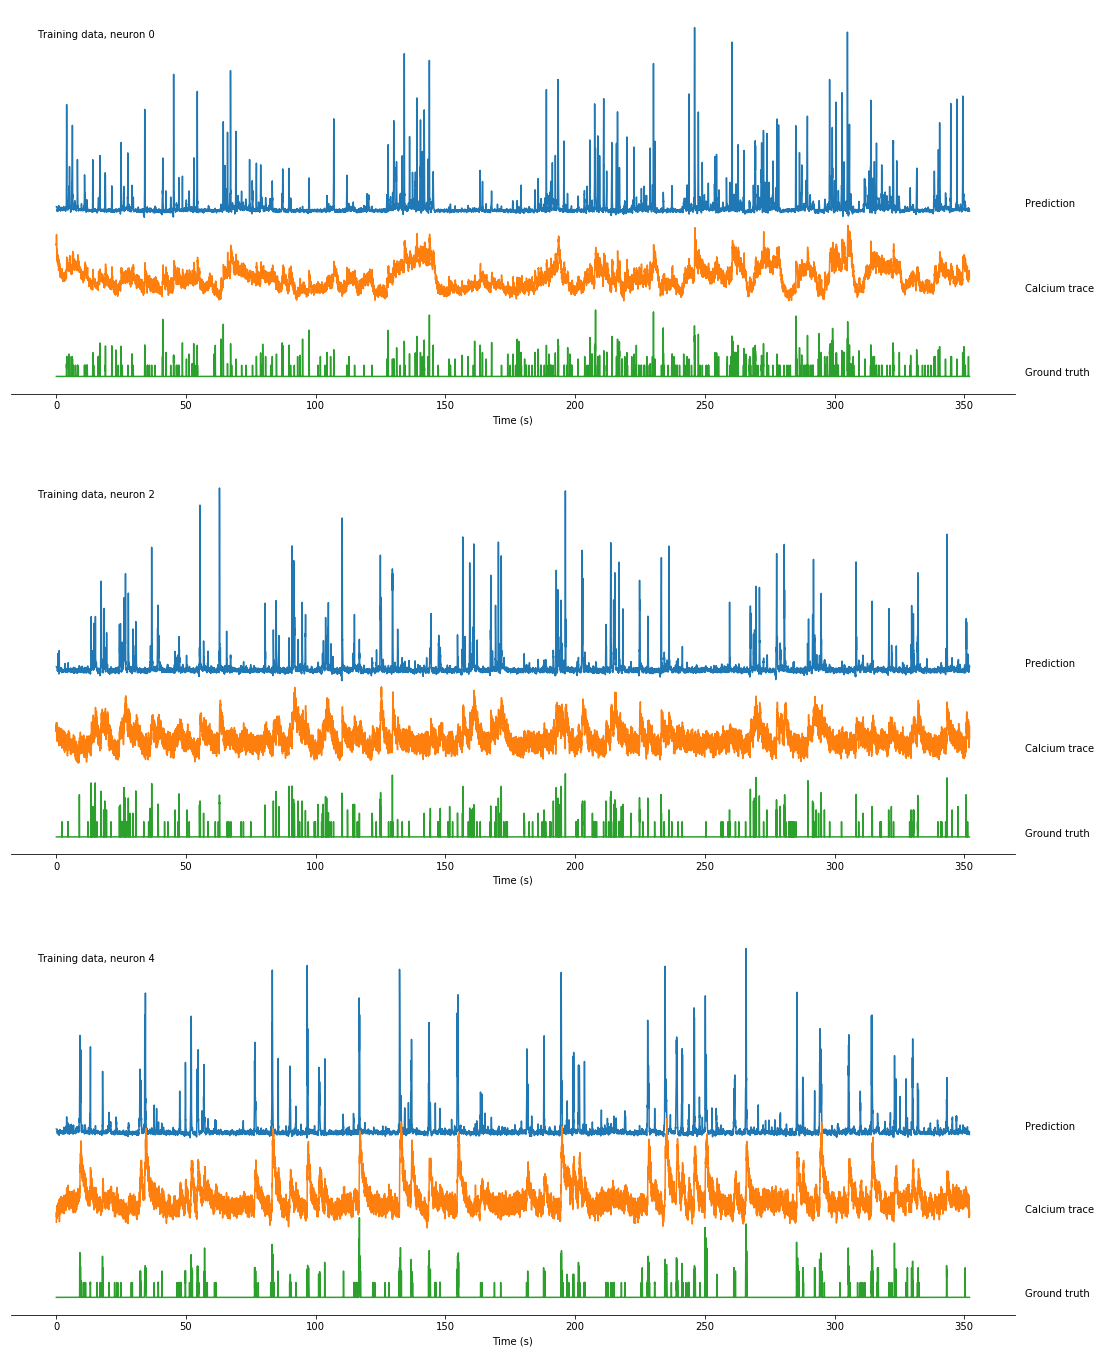

In [199]:
f = plt.figure(figsize=(18,24))

# choose time window
window = np.arange(0,35200)
time_sec = window/100

for ii,neuron_index in zip(range(3),[0,2,4]):
    # plot predictions, calcium traces and ground truth for the test dataset
    ax = plt.subplot(3,1,ii+1)
    ax.plot(time_sec,x_test_predict[window,neuron_index])
    ax.plot(time_sec,x_test[window,neuron_index]-4)
    ax.plot(time_sec,(y_test[window,neuron_index])/5-8)

    # Labels and axes
    plt.text(1.01*plt.xlim()[1],0, 'Prediction')
    plt.text(1.01*plt.xlim()[1],-4, 'Calcium trace')
    plt.text(1.01*plt.xlim()[1],-8, 'Ground truth')

    plt.text(-0.02*plt.xlim()[1],8, 'Training data, neuron %s' % neuron_index)


    plt.xlabel('Time (s)')

    ax.get_yaxis().set_visible(False)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)

# Plot results (zoom-in)
Plot the results (predictions, calcium trace, ground truth) for the same selected neurons for a short time-window.

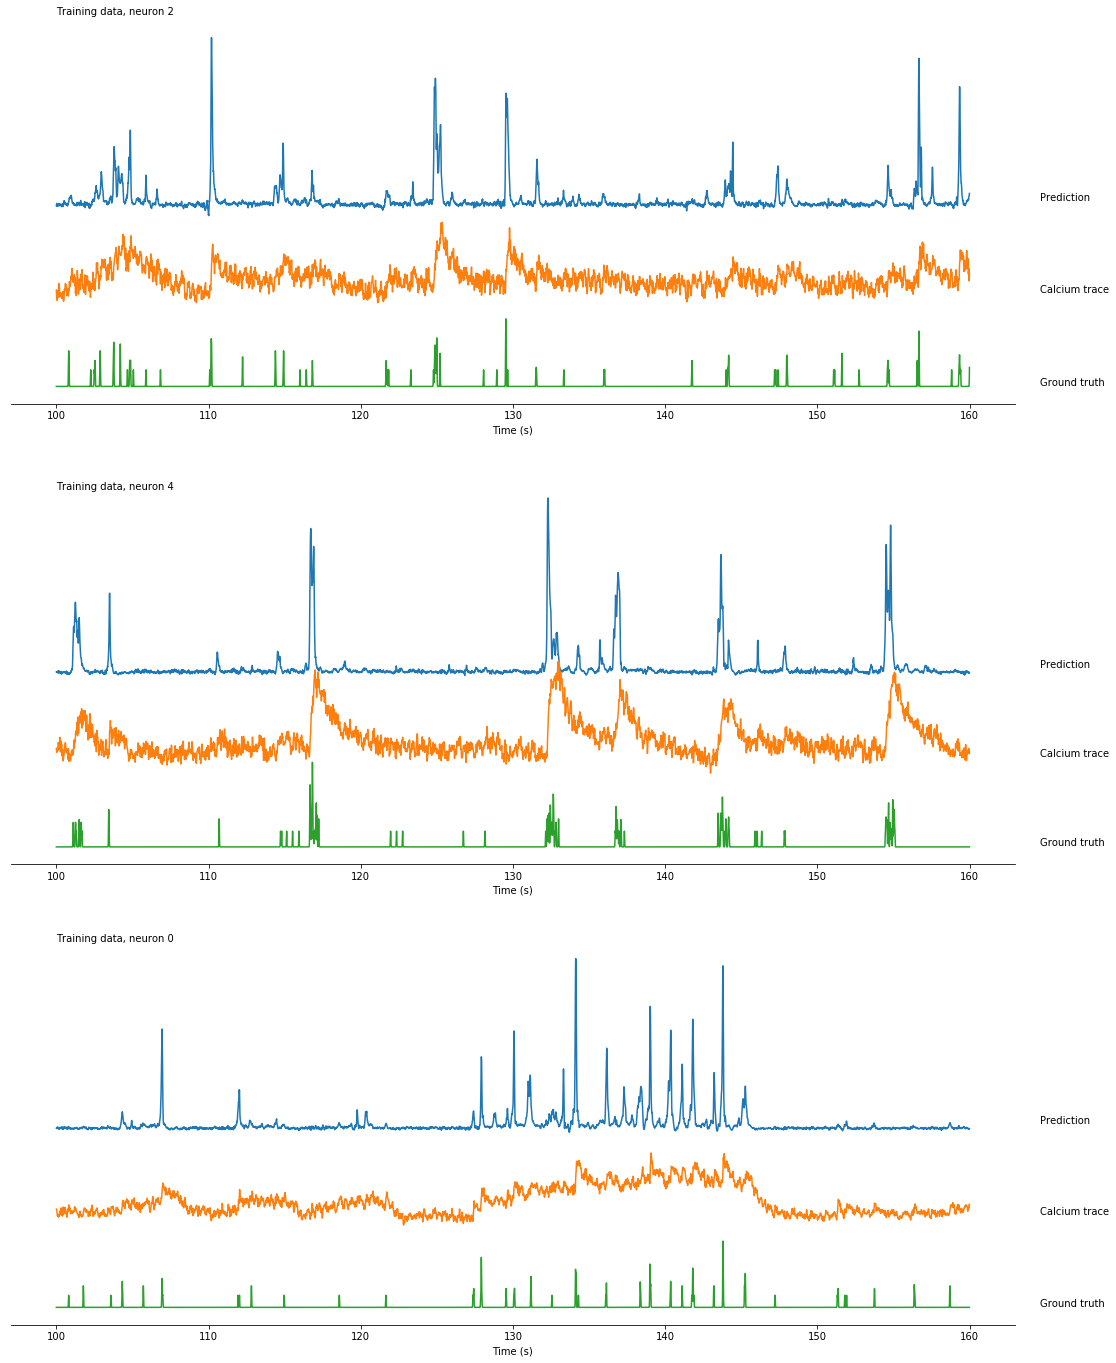

In [202]:
f = plt.figure(figsize=(18,24))

# choose time window
window = np.arange(10000,16000)
time_sec = window/100

for ii,neuron_index in zip(range(3),[2,4,0]):
    # plot predictions, calcium traces and ground truth for the test dataset
    ax = plt.subplot(3,1,ii+1)
    ax.plot(time_sec,x_test_predict[window,neuron_index])
    ax.plot(time_sec,x_test[window,neuron_index]-4)
    ax.plot(time_sec,(y_test[window,neuron_index])/5-8)

    # Labels and axes
    plt.text(1.01*plt.xlim()[1],0, 'Prediction')
    plt.text(1.01*plt.xlim()[1],-4, 'Calcium trace')
    plt.text(1.01*plt.xlim()[1],-8, 'Ground truth')

    plt.text(time_sec[0],8, 'Training data, neuron %s' % neuron_index)


    plt.xlabel('Time (s)')

    ax.get_yaxis().set_visible(False)
    sns.despine(fig=None, ax=None, top=True, right=True, left=True, bottom=False, offset=None, trim=False)